In [1]:
# Try to model the coronavirus data using the ODE fits from pymc3

In [2]:
import pandas as pd

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt

In [5]:
# clean up date formatting in plots
import datetime
import matplotlib.dates as mdates
import matplotlib.units as munits
import matplotlib.ticker as ticker
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter


In [6]:
%matplotlib inline

In [7]:
# TODO
# Set plot style defaults

In [8]:
# Get the US data from covidtracking.com: https://covidtracking.com/api/states/daily
data = pd.read_json('USdata/daily.json')

In [9]:
data['timestamp']=pd.to_datetime(data['date'],format="%Y%m%d")

In [10]:
dataUS=data.drop('date',axis=1).groupby('timestamp').sum()

In [11]:
dataUS.head()

positive  negative  pending  hospitalizedCurrently  \
timestamp                                                        
2020-03-04     118.0     748.0    103.0                    0.0   
2020-03-05     176.0     953.0    197.0                    0.0   
2020-03-06     223.0    1571.0    458.0                    0.0   
2020-03-07     341.0    1809.0    602.0                    0.0   
2020-03-08     417.0    2335.0    347.0                    0.0   

            hospitalizedCumulative  inIcuCurrently  inIcuCumulative  \
timestamp                                                             
2020-03-04                     0.0             0.0              0.0   
2020-03-05                     0.0             0.0              0.0   
2020-03-06                     0.0             0.0              0.0   
2020-03-07                     0.0             0.0              0.0   
2020-03-08                     0.0             0.0              0.0   

            onVentilatorCurrently  onVentilatorCumulative  recovered  ...  \
timestamp                                                             ...   
2020-03-04                    0.0                     0.0        0.0  ...   
2020-03-05                    0.0                     0.0        0.0  ...   
2020-03-06                    0.0                     0.0        0.0  ...   
2020-03-07                    0.0                     0.0        0.0  ...   
2020-03-08                    0.0                     0.0        0.0  ...   

            hospitalized  total  totalTestResults  posNeg  fips  \
timestamp                                                         
2020-03-04           0.0    969               866     866   425   
2020-03-05           0.0   1326              1129    1129   728   
2020-03-06           0.0   2252              1794    1794  1031   
2020-03-07           0.0   2752              2150    2150  1477   
2020-03-08           0.0   3099              2752    2752  1477   

            deathIncrease  hospitalizedIncrease  negativeIncrease  \
timestamp                                                           
2020-03-04            0.0                   0.0               0.0   
2020-03-05            1.0                   0.0              99.0   
2020-03-06            3.0                   0.0             507.0   
2020-03-07            2.0                   0.0             194.0   
2020-03-08            2.0                   0.0             526.0   

            positiveIncrease  totalTestResultsIncrease  
timestamp                                               
2020-03-04               0.0                       0.0  
2020-03-05              55.0                     154.0  
2020-03-06              44.0                     551.0  
2020-03-07             113.0                     307.0  
2020-03-08              76.0                     602.0  

[5 rows x 21 columns]

In [12]:
pop = 329.1e6 # US population

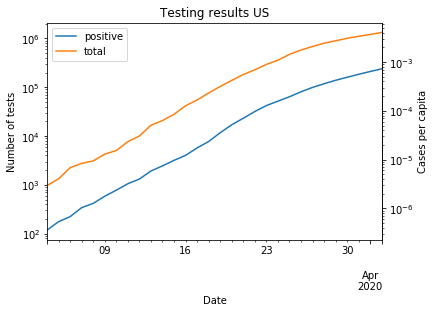

In [13]:
fig, ax = plt.subplots()
dataUS.plot(y=['positive','total'],ax=ax)
ax.set_yscale('log')
ax.set_xlabel('Date')
ax.set_ylabel('Number of tests')
ax_percap = ax.secondary_yaxis('right', functions=(lambda x: x/pop, lambda x: x*pop))
ax_percap.set_ylabel('Cases per capita')
ax.set_title('Testing results US');
plt.show();


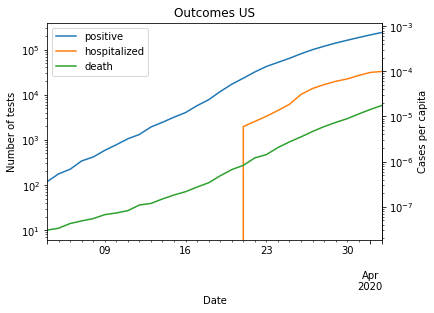

In [14]:
fig,ax = plt.subplots()
dataUS.plot(y=['positive','hospitalized','death'],ax=ax)
ax.set_yscale('log')
ax.set_xlabel('Date')
ax.set_ylabel('Number of tests')
ax_percap = ax.secondary_yaxis('right', functions=(lambda x: x/pop, lambda x: x*pop))
ax_percap.set_ylabel('Cases per capita')
ax.set_title('Outcomes US')
plt.show();

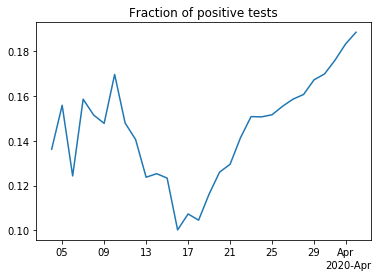

In [15]:
plt.figure()
plt.plot(dataUS.index,dataUS['positive']/(dataUS['positive']+dataUS['negative']))
plt.title('Fraction of positive tests');

Scratch work for calculating the doubling rate $r$ from the day-to-day fractional change $d$:
$$
\begin{gathered}
(1+d)^r = 2 \\
r \ln (1+d) = \ln 2 \\
r = \frac{\ln 2}{\ln(1+d)} \\
1+d = 2^{1/r} \\
d = 2^{1/r}-1
\end{gathered}
$$

In [16]:
def change2double(x):
    # convert daily fraction change to doubling rate
    return np.divide(np.log(2.),np.log(1+x),out=np.full_like(x,np.inf),where=x!=0)

def double2change(x):
    # convert doubling rate to fractional change
    return np.power(2.,1./x)-1

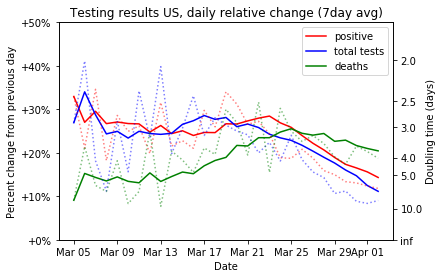

In [17]:
fig, ax = plt.subplots()
deltas=(dataUS.diff()/dataUS) #.plot(y=['positive','total'],kind='bar',ax=ax)
ax.plot(deltas.index, 100*deltas['positive'].rolling('7D').mean(),'r',label='positive (7 day avg)')
ax.plot(deltas.index, 100*deltas['total'].rolling('7D').mean(),'b',label='total tests (7 day avg)')
ax.plot(deltas.index, 100*deltas['death'].rolling('7D').mean(),'g',label='total deaths (7 day avg)')
ax.plot(deltas.index, 100*deltas['positive'],'r:',alpha=0.5,label='positive (raw)')
ax.plot(deltas.index, 100*deltas['total'],'b:',alpha=0.5,label='total tests (raw)')
ax.plot(deltas.index, 100*deltas['death'],'g:',alpha=0.5,label='deaths (raw)')
#plt.yscale('log')
ax.set_xlabel('Date')
ax.set_ylabel('Percent change from previous day')
ax.set_title('Testing results US, daily relative change (7day avg)');
ax.set_ylim((0.,50))
#set ticks every week
#ax.xaxis.set_major_locator(mdates.WeekDayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%+.0f%%"))
ax_doub = ax.twinx()
ax_doub.set_ylabel('Doubling time (days)')
yticks=ax.get_yticks()
ax_doub.set_ylim(ax.get_ylim())
# CHECK if the array below is outside the primary axis limits,
# it will be interpreted as 'graph coordinates' rather than data values
roundedD = np.array([2.,2.5,3.,4.,5.,10.,np.inf])
ax_doub.set_yticks(100*double2change(roundedD))
doublabs = ['{:.1f}'.format(i) for i in roundedD]
ax_doub.set_yticklabels(doublabs)
ax.legend(['positive','total tests','deaths'],loc='upper right')
plt.show();

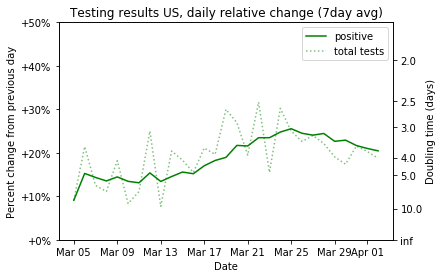

In [18]:
fig, ax = plt.subplots()
deltas=(dataUS.diff()/dataUS) #.plot(y=['positive','total'],kind='bar',ax=ax)
#ax.plot(deltas.index, 100*deltas['positive'].rolling('7D').mean(),'r',label='positive (7 day avg)')
#ax.plot(deltas.index, 100*deltas['total'].rolling('7D').mean(),'b',label='total tests (7 day avg)')
ax.plot(deltas.index, 100*deltas['death'].rolling('7D').mean(),'g',label='total deaths (7 day avg)')
#ax.plot(deltas.index, 100*deltas['positive'],'r:',alpha=0.5,label='positive (raw)')
#ax.plot(deltas.index, 100*deltas['total'],'b:',alpha=0.5,label='total tests (raw)')
ax.plot(deltas.index, 100*deltas['death'],'g:',alpha=0.5,label='deaths (raw)')
#plt.yscale('log')
ax.set_xlabel('Date')
ax.set_ylabel('Percent change from previous day')
ax.set_title('Testing results US, daily relative change (7day avg)');
ax.set_ylim((0.,50))
#set ticks every week
#ax.xaxis.set_major_locator(mdates.WeekDayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%+.0f%%"))
ax_doub = ax.twinx()
ax_doub.set_ylabel('Doubling time (days)')
yticks=ax.get_yticks()
ax_doub.set_ylim(ax.get_ylim())
# CHECK if the array below is outside the primary axis limits,
# it will be interpreted as 'graph coordinates' rather than data values
roundedD = np.array([2.,2.5,3.,4.,5.,10.,np.inf])
ax_doub.set_yticks(100*double2change(roundedD))
doublabs = ['{:.1f}'.format(i) for i in roundedD]
ax_doub.set_yticklabels(doublabs)
ax.legend(['positive','total tests','deaths'],loc='upper right')
plt.show();

In [19]:
#top5 as of 20200401
#top5=data[data['date']==20200401].loc[:,['death','state']].sort_values('death',ascending=False)[:5]['state']
top5=AlStates=['NY','WA','CA','GA','NJ','LA','FL']
#rest=data[data['date']==20200401].loc[:,['death','state']].sort_values('death',ascending=False)[5:]['state']

In [20]:
topdata=data[data['state'].isin(top5)].drop(['date'],axis=1).groupby('timestamp').sum().sort_values('timestamp')
restdata=data[~data['state'].isin(top5)].drop(['date'],axis=1).groupby('timestamp').sum().sort_values('timestamp')

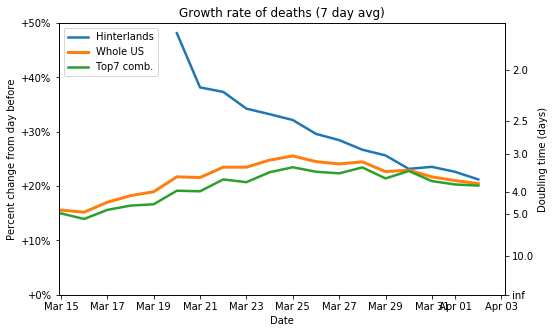

In [21]:
sortup=True
days2avg = 7
restdata.sort_values('timestamp',ascending=sortup,inplace=True)
fig, ax = plt.subplots(figsize=(8,5))
#for i in top5:
#    thisstate=data[data['state']==i].sort_values('timestamp',ascending=sortup)
#    ax.plot(thisstate['timestamp'],(thisstate['deathIncrease']/thisstate['death']).rolling(days2avg).mean()*100,label=i)
ax.plot(restdata.index,(restdata['deathIncrease']/restdata['death']).rolling(days2avg).mean()*100,lw=2.5,label='Hinterlands')
ax.plot(dataUS.index,(dataUS['deathIncrease']/dataUS['death']).rolling(days2avg).mean()*100,lw=3,label='Whole US')
ax.plot(topdata.index,(topdata['deathIncrease']/topdata['death']).rolling(days2avg).mean()*100,lw=2.5,label='Top7 comb.')
ax.legend(loc='upper left')
ax.set_title('Growth rate of deaths ({} day avg)'.format(days2avg))
ax.set_xlabel('Date')
ax.set_ylabel('Percent change from day before')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%+.0f%%"))
ax.set_ylim(0,50)
ax.set_xlim(737498.9, None)
ax_doub = ax.twinx()
ax_doub.set_ylabel('Doubling time (days)')
yticks=ax.get_yticks()
ax_doub.set_ylim(ax.get_ylim())
# CHECK if the array below is outside the primary axis limits,
# it will be interpreted as 'graph coordinates' rather than data values
roundedD = np.array([2.,2.5,3.,4.,5.,10.,np.inf])
ax_doub.set_yticks(100*double2change(roundedD))
doublabs = ['{:.1f}'.format(i) for i in roundedD]
ax_doub.set_yticklabels(doublabs)
plt.show()

## Checking Al Sanders' data

In [22]:
data[data['state'].isin(AlStates)].loc[:,['state','death','timestamp']].pivot(index='timestamp',columns='state',values='death').tail(12)

state          CA     FL     GA     LA     NJ      NY     WA
timestamp                                                   
2020-03-22   27.0   13.0   23.0   20.0   20.0   114.0   94.0
2020-03-23   27.0   14.0   25.0   34.0   27.0   114.0   95.0
2020-03-24   40.0   18.0   32.0   46.0   44.0   210.0  110.0
2020-03-25   53.0   22.0   40.0   65.0   62.0   285.0  123.0
2020-03-26   65.0   28.0   48.0   83.0   81.0   385.0  132.0
2020-03-27   78.0   34.0   64.0  119.0  108.0   519.0  147.0
2020-03-28  101.0   54.0   69.0  137.0  140.0   728.0  175.0
2020-03-29  123.0   56.0   80.0  151.0  161.0   965.0  189.0
2020-03-30  133.0   63.0   87.0  185.0  198.0  1218.0  195.0
2020-03-31  153.0   77.0  111.0  239.0  267.0  1550.0  195.0
2020-04-01  171.0   87.0  139.0  273.0  355.0  1941.0  224.0
2020-04-02  203.0  128.0  163.0  310.0  537.0  2373.0  247.0

In [23]:
data[~data['state'].isin(AlStates)].groupby('timestamp').sum()['death'].tail(12)

timestamp
2020-03-22      87.0
2020-03-23     135.0
2020-03-24     175.0
2020-03-25     250.0
2020-03-26     341.0
2020-03-27     461.0
2020-03-28     561.0
2020-03-29     703.0
2020-03-30     860.0
2020-03-31    1154.0
2020-04-01    1510.0
2020-04-02    1823.0
Name: death, dtype: float64

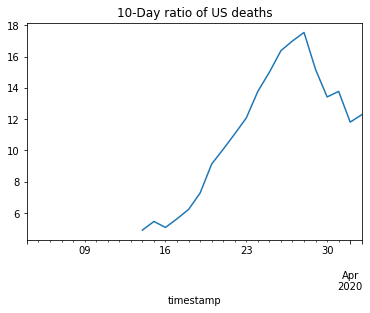

In [24]:
(dataUS['death']/dataUS['death'].shift(10)).plot(title='10-Day ratio of US deaths')

In [25]:
# zero for time fit
t0 = pd.to_datetime('2020-03-22')

In [26]:
day=(restdata.index.values-np.full_like(restdata.index.values,t0))/pd.Timedelta('1D')

In [27]:
A=np.vstack([day,np.ones_like(day)]).T

In [28]:
x,_,_,_=np.linalg.lstsq(A[-10:,:],np.log(restdata['death'])[-10:])

/home/corcoted/miniconda3/envs/virusmodel/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-28-e0f8fe9a06a3>:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x,_,_,_=np.linalg.lstsq(A[-10:,:],np.log(restdata['death'])[-10:])


In [29]:
x

array([0.25376774, 4.76777276])

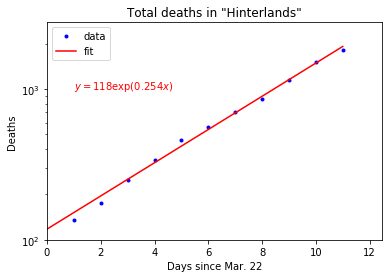

In [30]:
plt.plot(day,(restdata['death']),'b.',label='data')
plt.plot(day,np.exp(day*x[0]+x[1]),'r-',label='fit')
plt.xlim(0,None)
plt.yscale('log')
plt.ylim(100,None)
plt.xlabel('Days since Mar. 22')
plt.ylabel('Deaths')
plt.title('Total deaths in "Hinterlands"')
plt.annotate('$y={:.0f} \exp({:.3f}x)$'.format(np.exp(x[1]),x[0]),(1,1000),c='r')
plt.legend()

In [31]:
restdata['death'].tail(12)

timestamp
2020-03-22      87.0
2020-03-23     135.0
2020-03-24     175.0
2020-03-25     250.0
2020-03-26     341.0
2020-03-27     461.0
2020-03-28     561.0
2020-03-29     703.0
2020-03-30     860.0
2020-03-31    1154.0
2020-04-01    1510.0
2020-04-02    1823.0
Name: death, dtype: float64

Text(0, 0.5, 'Total deaths (2020-04-02 00:00:00)')

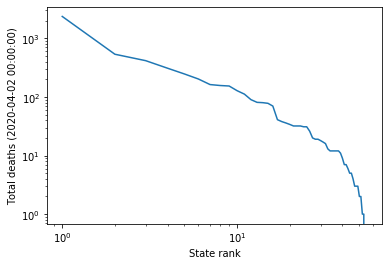

In [55]:
fig,ax = plt.subplots()
ax.plot(np.arange(56)+1,data.loc[:,['state','death','timestamp']].pivot(index='timestamp',columns='state',values='death').iloc[-1,:].sort_values(ascending=False))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('State rank')
ax.set_ylabel('Total deaths ({})'.format(data.iloc[0,:]['timestamp']))

In [33]:
#red/blue based on party of governor
bluestates=['CA','CO','CT','DE','HI',
           'IL','KS','KY','LA','ME',
           'MI','MO','NV','NJ','NM',
           'NY','NC','OR','PA','RI',
           'VA','WA','WI','MN','DC','MT']
redstates=['AL','AK','AZ','AR','FL',
          'GA','ID','IN','IA','MD',
          'MA','MS','NE','NH','ND',
          'OH','OK','SC','SD','TN',
          'TX','UT','VT','WV','WY']
territories=['AS', 'GU', 'MP', 'PR', 'VI']

In [34]:
reddata=data[data['state'].isin(redstates)].drop(['date'],axis=1).groupby('timestamp').sum().sort_values('timestamp')
bluedata=data[data['state'].isin(bluestates)].drop(['date'],axis=1).groupby('timestamp').sum().sort_values('timestamp')
terrdata=data[data['state'].isin(territories)].drop(['date'],axis=1).groupby('timestamp').sum().sort_values('timestamp')

Text(0.5, 1.0, 'Total deaths')

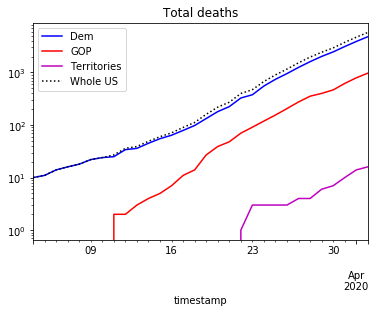

In [35]:
fig, ax = plt.subplots()
bluedata['death'].plot(ax=ax,color='b')
reddata['death'].plot(ax=ax,color='r')
terrdata['death'].plot(ax=ax,color='m')
dataUS['death'].plot(ax=ax,color='k',linestyle=':')
ax.set_yscale('log')
ax.legend(['Dem','GOP','Territories','Whole US'])
ax.set_title('Total deaths')

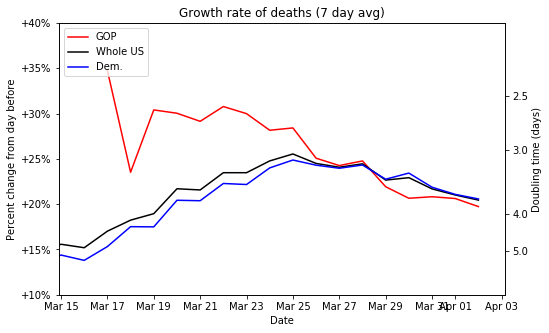

In [36]:
sortup=True
days2avg = 7
restdata.sort_values('timestamp',ascending=sortup,inplace=True)
fig, ax = plt.subplots(figsize=(8,5))
#for i in top5:
#    thisstate=data[data['state']==i].sort_values('timestamp',ascending=sortup)
#    ax.plot(thisstate['timestamp'],(thisstate['deathIncrease']/thisstate['death']).rolling(days2avg).mean()*100,label=i)
ax.plot(reddata.index,(reddata['deathIncrease']/reddata['death']).rolling(days2avg).mean()*100,label='GOP',color='r')
ax.plot(dataUS.index,(dataUS['deathIncrease']/dataUS['death']).rolling(days2avg).mean()*100,label='Whole US',color='k')
ax.plot(bluedata.index,(bluedata['deathIncrease']/bluedata['death']).rolling(days2avg).mean()*100,label='Dem.',color='b')
ax.legend(loc='upper left')
ax.set_title('Growth rate of deaths ({} day avg)'.format(days2avg))
ax.set_xlabel('Date')
ax.set_ylabel('Percent change from day before')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%+.0f%%"))
ax.set_ylim(10,40)
ax.set_xlim(737498.9, None)
ax_doub = ax.twinx()
ax_doub.set_ylabel('Doubling time (days)')
yticks=ax.get_yticks()
ax_doub.set_ylim(ax.get_ylim())
# CHECK if the array below is outside the primary axis limits,
# it will be interpreted as 'graph coordinates' rather than data values
roundedD = np.array([2.5,3.,4.,5.])
ax_doub.set_yticks(100*double2change(roundedD))
doublabs = ['{:.1f}'.format(i) for i in roundedD]
ax_doub.set_yticklabels(doublabs)
plt.show()

## Snake plot

In [41]:
allstates=data['state'].unique()

In [172]:
xdata=data.loc[:,['state','timestamp','death']].pivot(index='timestamp',columns='state',values='death').sort_values('timestamp').values.flatten()

In [173]:
ydata=data.loc[:,['state','timestamp','deathIncrease']].pivot(index='timestamp',columns='state',values='deathIncrease').sort_values('timestamp').rolling(7).sum().values.flatten()

In [174]:
xdata2=np.ma.masked_where((xdata==0) | (ydata==0) | (np.isnan(xdata)) | (np.isnan(ydata)),xdata).compressed()
ydata=np.ma.masked_where((xdata==0) | (ydata==0)|  (np.isnan(xdata)) | (np.isnan(ydata)),ydata).compressed()

In [175]:
ydata

array([2.000e+00, 1.400e+01, 4.000e+00, 2.000e+00, 1.000e+00, 1.800e+01,
       4.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.700e+01, 5.000e+00,
       1.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.100e+01,
       5.000e+00, 1.000e+00, 4.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
       2.000e+00, 3.000e+00, 1.000e+00, 2.200e+01, 6.000e+00, 1.000e+00,
       4.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
       2.000e+00, 1.000e+00, 7.000e+00, 1.000e+00, 1.000e+00, 2.000e+01,
       1.100e+01, 1.000e+00, 6.000e+00, 1.000e+00, 1.000e+00, 2.000e+00,
       1.000e+00, 1.000e+00, 4.000e+00, 3.000e+00, 1.000e+00, 7.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 2.400e+01, 1.300e+01, 2.000e+00,
       5.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
       6.000e+00, 4.000e+00, 1.000e+00, 1.200e+01, 3.000e+00, 1.000e+00,
       1.000e+00, 2.000e+00, 1.000e+00, 2.800e+01, 1.400e+01, 2.000e+00,
       1.000e+00, 6.000e+00, 1.000e+01, 4.000e+00, 

In [176]:
A= np.vstack([np.log(xdata2),np.ones_like(xdata2)]).T

In [177]:
A

array([[0.69314718, 1.        ],
       [3.17805383, 1.        ],
       [1.38629436, 1.        ],
       ...,
       [5.50938834, 1.        ],
       [3.4339872 , 1.        ],
       [0.69314718, 1.        ]])

In [178]:
x,_,_,_=np.linalg.lstsq(A,np.log(ydata))

<ipython-input-178-ee7647233d21>:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x,_,_,_=np.linalg.lstsq(A,np.log(ydata))


In [179]:
x

array([ 0.94979287, -0.02296418])

Text(0.5, 1.0, 'All states')

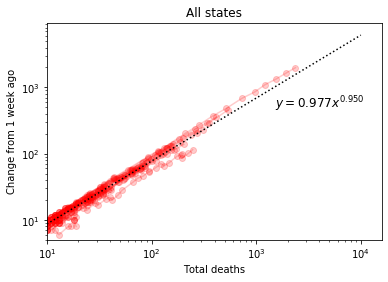

In [195]:
fig, ax = plt.subplots()
for s in allstates:
    ax.plot(data[data['state']==s].sort_values('timestamp')['death'],data[data['state']==s].sort_values('timestamp')['deathIncrease'].rolling(7).sum()
            ,color='r',alpha=0.2,marker='o')
ax.plot(np.geomspace(10,1e4),np.exp(x[0]*np.log(np.geomspace(10,1e4))+x[1]),'k:')
ax.annotate(r'$y={:.3f}'.format(np.exp(x[1]))+'x^{'+'{:.3f}'.format(x[0])+'}$',(1500,500),size='large')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(10,None)
ax.set_ylim(5,None)
ax.set_ylabel('Change from 1 week ago')
ax.set_xlabel('Total deaths')
ax.set_title('All states')